# Sidekick - Output as input

#### Model
We change completely the approach. Instead of using the time as input and trying to predict the output at new time indices, we now consider the pledged money at each time step as input ($\mathbf{y}$ becomes $\mathbf{x}$) and the last time index as the output. That is, we have now a dataset $\mathcal{D} = \left\{ (\mathbf{x}^{(p)}, y^{(p)}) \mid p = 1, ..., P \right\}$ with $\mathbf{x}^{(p)} = \mathbf{y}_{1:t}^{(p)}$ and $\mathbf{y}^{(p)} = y_T^{(p)}$. We then have $X = \left[\mathbf{x}^{(p)}\right]_{p=1}^P$ a $(P \times t)$ matrix and $\mathbf{y} = \left[y_T^{(p)}\right]_{p=1}^P$ a $(P \times 1)$ target vector. The difference with the second approach is that now the features for each project are the amount of pledged money at different time step and not the same (shared) input values ($1,...,T$).

Our goal now is to predict, for a new project $p$, the final amount of pledged money $f_*^{(p)} = y_T^{(p)} = f(\mathbf{x}^{(p)}) = f(\mathbf{y}_{1:t}^{(p)})$ for the money received up to time $t$ $X_*^{(p)} = \mathbf{y}_{1:t}^{(p)}$ after observing the total pledged money for all projects $\mathbf{y} = \left[y_T^{(p)}\right]_{p=1}^P$ and the money they received up to time $t$, $X = \left[ \mathbf{y}_{1:t}^{(p)} \right]_{p=1}^P$. In the GP framework, we can compute this prediction using

$$f_* \mid X, \mathbf{y}, X_* \sim \mathcal{N}\left(\overline{f}_*, \text{ cov}(f_*)  \right) \\
\overline{f}_* = K(X_*, X) \left[ K(X, X) + \sigma_n^2I \right]^{-1}\mathbf{y} \\
\text{cov}(f_*) = K(X_*, X_*) - K(X_*, X)\left[ K(X, X) + \sigma_n^2I \right]^{-1}K(X, X_*).
$$ 

As seen in [this plot](http://localhost:8888/notebooks/notebooks/sidekick-1-eda.ipynb#Output-as-input---Global), it seems impossible to do a regression considering all the projects together. However, the two modes corresponding to the successful and failed projects are clearly distinguisable. Therefore we try to perform the regression on each of the two classes separately, using an EM algorithm **[EM DETAILS GO HERE]**

#### Results
Mixture of (GP) models can probably be used.

In [1]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import scipy as sp
import GPy
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick
from model.utils.progressbar import ProgressBar

DATA_DIR = "../data/sidekick"

def predict_total_pledged(project, t, samples, m_s_test, m_f_test, pi, X_s, y_s, X_f, y_f):
    """Predict the total pledged money for a given project using a mixture of two GPs:
    
        p(Y_T | y_{1:t}, theta) = pi * p(y_T | y{1:t}, theta_s) + (1-pi) * p(y_T | y{1:t}, theta_f)
        
        where pi is the proportion of successful projects. Returns also the classification.
    """
    money = np.expand_dims(project.money[samples], axis=0)
    X_observed = np.ndarray(shape=(1, t), buffer=money, dtype=float)
    
    l_s = m_s_test.rbf.lengthscale
    sigma_f_s = m_s_test.rbf.variance
    sigma_n_s = m_s_test.Gaussian_noise.variance
    mean_s, var_s, likelihood_s = gaussian_process_regression(X_s, y_s, X_observed, k, 
                                                              l=l_s, 
                                                              sigma_n=sigma_n_s, 
                                                              sigma_f=sigma_f_s)
    l_f = m_f_test.rbf.lengthscale
    sigma_f_f = m_f_test.rbf.variance
    sigma_n_f = m_f_test.Gaussian_noise.variance
    mean_f, var_f, likelihood_f = gaussian_process_regression(X_f, y_f, X_observed, k, 
                                                              l=l_f, 
                                                              sigma_n=sigma_n_f, 
                                                              sigma_f=sigma_f_f)
    y_pred = (mean_s + mean_f) / 2
    likelihood_s = gp_log_likelihood(X_observed, y_pred, l_s, sigma_f_s, sigma_n_s)
    likelihood_f = gp_log_likelihood(X_observed, y_pred, l_f, sigma_f_f, sigma_n_f)
    
    print("Successful:", mean_s, var_s, likelihood_s)
    print("Failed:", mean_f, var_f, likelihood_f)
    print("Predicted: %s (%s)" % (y_pred, "successful" if likelihood_s > likelihood_f else "failed"))
    
    #print(likelihood_s)
    #print(likelihood_f)
    
    return likelihood_s > likelihood_f, y_pred

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples


def k(xp, xq , l, sigma_f):
    """Covariance functions with squared exponential of length-scale l and signal noise sigma_f."""
    return sigma_f * np.exp(-0.5 * np.linalg.norm(xp - xq) / float(l**2))
    #return sigma_f * xp * xq


def K(x1, x2, l=1.0, sigma_f=1.0):
    """Compute the covariance matrix from the observations x."""
    cov_matrix = np.zeros((len(x1), len(x2)))
    for i, p in enumerate(x1):
        for j, q in enumerate(x2):
            cov_matrix[i, j] = k(p, q, l, sigma_f)
    return cov_matrix

def gp_log_likelihood(x, y, l=1.0, sigma_n=0.0, sigma_f=1.0):
    n = len(x)
    L = np.linalg.cholesky(K(x, x, l, sigma_f) + sigma_n * np.eye(n))
    a = sp.linalg.solve_triangular(L.T, sp.linalg.solve_triangular(L, y, lower=True))
    lml = -0.5 * np.sum(y * a) - np.sum(np.log(np.diag(L))) - n * 0.918938533205
    return lml


def gaussian_process_regression(X, y, x_test, k, l=1.0, sigma_n=0.0, sigma_f=1.0):
    """
    Computes a regression using Gaussian Process using observations x and y = f(x) and a covariance function k.
    
    :param X        Inputs (NxD)
    :param y        Values at indices x (= f(x))
    :param x_test   Indices to get predicted values
    :param k        Covariance function
    :param sigma_n  Observations noise
    :return:        Mean m, variance var and log marginal likelihood lml
    """
    n = len(y)
    n_test = len(x_test)
    # Cholesky decompostion
    L = np.linalg.cholesky(K(X, X, l, sigma_f) + sigma_n * np.eye(n))
    a = sp.linalg.solve_triangular(L.T, sp.linalg.solve_triangular(L, y, lower=True))
    k_star = K(X, x_test, l, sigma_f)
    # Predictive mean
    m = np.dot(k_star.T, a)
    # Predictive variance
    v = sp.linalg.solve_triangular(L, k_star, lower=True)
    var = K(x_test, x_test, l, sigma_f) - np.dot(np.transpose(v), v)
    # Log maginal likelihood (last term is log2π / 2)
    #lml = -0.5 * np.sum(y * a) - np.sum(np.log(np.diag(L))) - n * 0.918938533205
    lml = 0
    return m, var + sigma_n * np.eye(n_test), lml

## Load data and separate successful from failed projects

In [2]:
sk = Sidekick(seed=2)
sk.load(light=True)
# projects_train, projects_test = sk.split()
# successful = sk.successful()
# failed = sk.failed()

Loading light data set (1000 data points)...
Data loaded.


### Train GP on all the projects

(734, 1)


GP_regression.,value,constraints,priors
rbf.variance,2.03356173999,+ve,
rbf.lengthscale,0.205822369664,+ve,
Gaussian_noise.variance,0.159304265445,+ve,


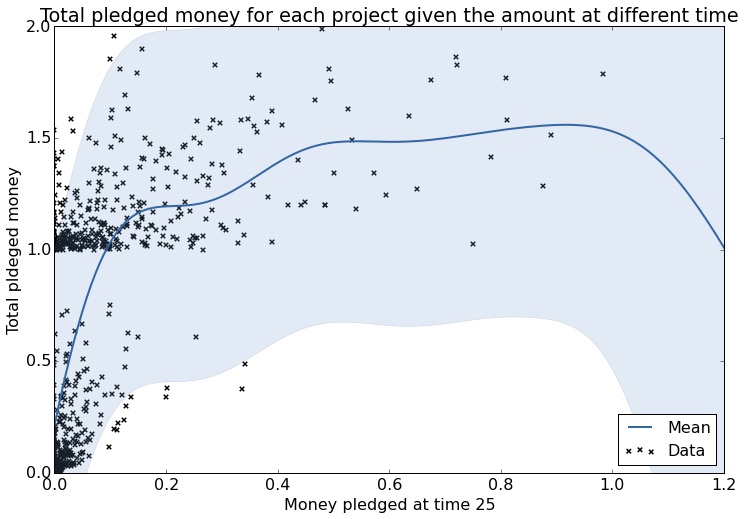

In [13]:
projects_train, projects_test = sk.split()

n_samples = 1
t0 = 1
t1 = 25
samples = subsample(t0, t1, n_samples)
t = len(samples)
samples = t1 - 1
T = 999
ARD = False
outlier_threshold = 2

projects_train_filtered = [p for p in projects_train if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold]
projects_test_filtered = [p for p in projects_test if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold]

X_train = np.ndarray(shape=(len(projects_train_filtered), t), buffer=np.array([p.money[samples] for p in projects_train_filtered]), dtype=float)
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), t), buffer=np.array([p.money[samples] for p in projects_test_filtered]), dtype=float)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)
        
print(X_train.shape)

kernel = GPy.kern.RBF(input_dim=t, ARD=ARD)
m = GPy.models.GPRegression(X_train, y_train, kernel)
m.optimize()
display(m)

if n_samples == 1: 
    plot = m.plot()
    plt.xlabel("Money pledged at time %s" % t1)
    plt.ylabel("Total pldeged money")
    plt.title("Total pledged money for each project given the amount at different time")
    plt.xlim([0, 1.2])
    plt.ylim([0, outlier_threshold])
    plt.legend(loc=4)
    plt.savefig("gp_output_input.pdf")

### Test prediction for one project

Predicted: 0.39908023048 (0.58650733137)
Actual: 0.0664
Goal: $5000
Pledged: $332


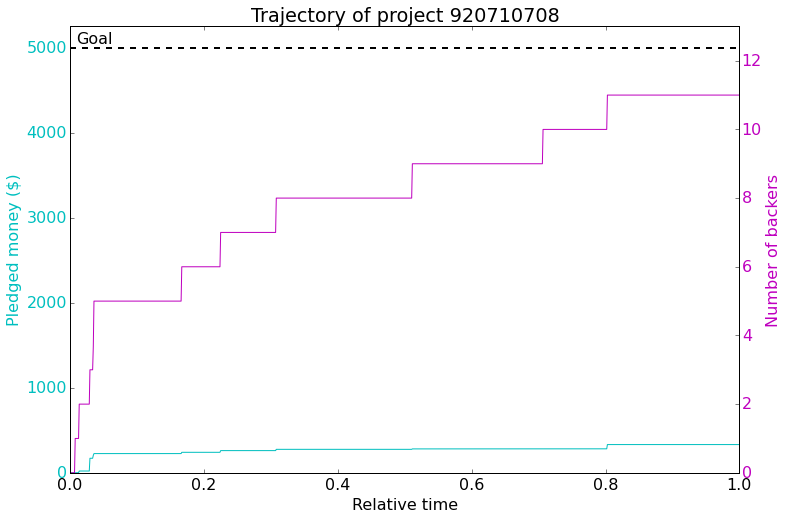

In [126]:
project_test = projects_test[0]

money = np.expand_dims(project_test.money[samples], axis=0)
X_observed = np.ndarray(shape=(1, t), buffer=money, dtype=float)

mean, var = m.predict(X_observed)

#print "Predicted as %0.4f (%0.4f)" % (yT_mean, yT_std)
print("Predicted: %s (%s)" % (mean[0,0], var[0, 0]))
print("Actual: %0.4f" % project_test.money[T])
project_test.plot()

### Evaluate on test set

In [151]:
se_successful = []
se_failed = []
se_total = []
accuracy = 0
for i, x_test in enumerate(X_test):
    x_test = np.expand_dims(x_test, axis=0)
    y_pred, y_var = m.predict(x_test)
    y_pred = y_pred[0, 0]
    y_var = y_var[0, 0]
    y_actual = y_test[i]
    se = (y_pred - y_actual)**2
    se_total.append(se)
    if y_test[i] >= 1.0:  # Project is successful
        se_successful.append(se)
    else:  # project is failed
        se_failed.append(se)
    if (y_pred >= 1 and y_actual >= 1) or (y_pred < 1 and y_actual < 1):
        accuracy += 1

rmse_successful = np.sqrt(np.mean(se_successful))
rmse_failed = np.sqrt(np.mean(se_failed))
rmse_total = np.sqrt(np.mean(se_total))
accuracy /= len(y_test)

print("Accuracy: ", accuracy)
print("RMSE: ", rmse_total)
print("RMSE successful: ", rmse_successful)
print("RMSE failed: ", rmse_failed)


Accuracy:  0.75
RMSE:  0.371128619944
RMSE successful:  0.424684560578
RMSE failed:  0.314114054727


### Parameters

In [19]:
N = 1000
seed = 2
t0 = 1
t1 = 25
n_samples = 25
T = 999
ARD = False
outliers_threshold = 2

N_train = int(floor(0.8*N))
N_test = N - N_train
samples = subsample(t0, t1, n_samples)
t = len(samples)
N_projects = sk.choose_n_projects(n=N)
projects_train = N_projects[:N_train]
projects_test = N_projects[N_train:]
successful = [p for p in projects_train if p.successful and p.money[T] < outliers_threshold]
failed = [p for p in projects_train if not p.successful]
pi = len(successful) / float(N_train)

print("Successful: %s (train)" % len(successful))
print("Failed: %s (train)" % len(failed))
print("p(successful) = %0.4f (prior)" % pi)

Successful: 323 (train)
Failed: 419 (train)
p(successful) = 0.4037 (prior)


## Train GP-RBF on successful projects

In [20]:
X_train_s = np.ndarray(shape=(len(successful), t), buffer=np.array([p.money[samples] for p in successful]), dtype=float) 
Y_train_s = np.expand_dims(np.array([p.money[T] for p in successful]), axis=1)
print(X_train_s.shape)
print(Y_train_s.shape)

kernel = GPy.kern.RBF(input_dim=t, ARD=ARD)
m_s = GPy.models.GPRegression(X_train_s, Y_train_s, kernel)
m_s.optimize()
#m_s.rbf.lengthscale = 0.01
display(m_s)

(323, 24)
(323, 1)


GP_regression.,value,constraints,priors
rbf.variance,0.911357235679,+ve,
rbf.lengthscale,4.06384400722,+ve,
Gaussian_noise.variance,0.0411339320035,+ve,


In [ ]:
def view_dimension(d, total):
    inputs = range(total)
    inputs.pop(d)
    fixed_inputs = [(i, 0) for i in inputs]
    return fixed_inputs

print(m_s.rbf.variance)
print(m_s.rbf.lengthscale)
f = view_dimension(9, t)
fig = m_s.plot(fixed_inputs=f)

## Train GP-RBF on failed projects

In [21]:
X_train_f = np.ndarray(shape=(len(failed), t), buffer=np.array([p.money[samples] for p in failed]), dtype=float) 
Y_train_f = np.expand_dims(np.array([p.money[T] for p in failed]), axis=1)
print(X_train_f.shape)
print(Y_train_f.shape)

kernel = GPy.kern.RBF(input_dim=t, ARD=ARD)
m_f = GPy.models.GPRegression(X_train_f, Y_train_f, kernel)
m_f.optimize()
display(m_f)

(419, 24)
(419, 1)


GP_regression.,value,constraints,priors
rbf.variance,0.17593652825,+ve,
rbf.lengthscale,0.393102800238,+ve,
Gaussian_noise.variance,0.0192127756946,+ve,


In [ ]:
print m_f.rbf.variance
print m_f.rbf.lengthscale
f = view_dimension(2, t)
fig = m_f.plot(fixed_inputs=f)

## Test experiment

Successful: [[ 1.17260856]] [[ 0.04349117]] -1.17740864965
Failed: [[ 0.29537371]] [[ 0.04333756]] -1.48227875653
Predicted: [[ 0.73399113]] (successful)
Classified as successful, CORRECT!
Actual total pledged money: 1.1591
Goal: $3000
Pledged: $3477


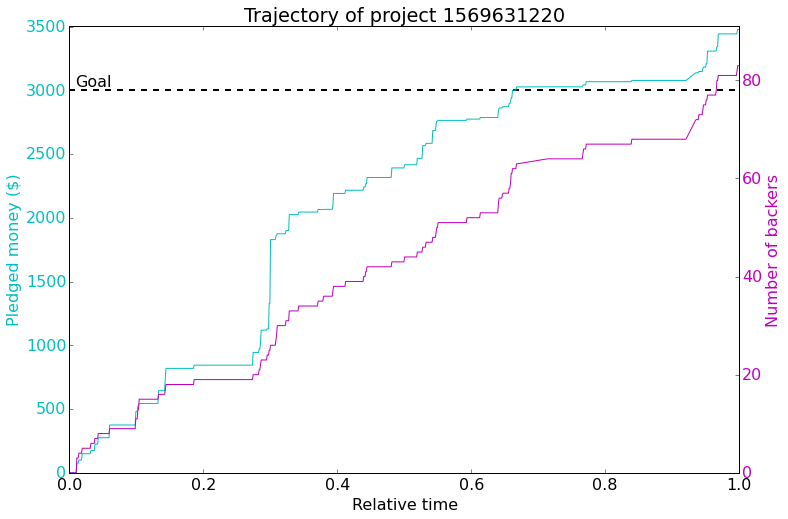

In [45]:
m_s_test = m_s.copy()
m_f_test = m_f.copy()
project_test = projects_test[15]

success, y_pred = predict_total_pledged(project_test, t, samples, m_s_test, m_f_test, pi, X_train_s, Y_train_s, X_train_f, Y_train_f)
#print "Predicted as %0.4f (%0.4f)" % (yT_mean, yT_std)
correct = (project_test.successful and success) or (not project_test.successful and not success)
print("Classified as %s, %s" % ("successful" if success else "failed", "CORRECT!" if correct else "wrong..."))
print("Actual total pledged money: %0.4f" % project_test.money[T])
project_test.plot()

## Run experiment

In [46]:
m_s_test = m_s.copy()
m_f_test = m_f.copy()
se_successful = 0
std_successful = 0
se_failed = 0
std_failed = 0
loss01 = 0
count_classifier_successful = 0
total_considered = 0
for project in projects_test:
    if project.money[T] < outliers_threshold:
        total_considered += 1
        success, y_pred = predict_total_pledged(project, t, samples, m_s_test, m_f_test, pi, X_train_s, Y_train_s, X_train_f, Y_train_f)
        if project.successful: 
                #se_successful += (project.money[T] - y_T_mean)**2
                #std_successful += yT_std
                if not success:  # Classification error
                    loss01 += 1
        else:  # project is failed
            #se_failed += (project.money[T] - y_T_mean)**2
            #std_failed += yT_std
            if success:  # Classification error
                loss01 += 1
        if success:
            count_classifier_successful += 1
        
#print "RMSE = %0.4f (±%0.4f)" % (np.sqrt(np.mean(se_successful)), std_successful / float(N_test))
print("01-Loss = %0.4f" % (loss01 / float(N_test)))
print("Classifed as successful: %s out of %s projects considered" % (count_classifier_successful, total_considered))

Successful: [[ 1.42026325]] [[ 0.0507332]] -1.19285840427
Failed: [[ 0.08728376]] [[ 0.19290718]] -1.55768642913
Predicted: [[ 0.7537735]] (successful)
Successful: [[ 1.14605523]] [[ 0.04246632]] -1.12847079112
Failed: [[ 0.18888631]] [[ 0.02975306]] -1.24342124041
Predicted: [[ 0.66747077]] (successful)
Successful: [[ 1.14103824]] [[ 0.04279014]] -1.15458124433
Failed: [[ 0.26645198]] [[ 0.03666679]] -1.37086200278
Predicted: [[ 0.70374511]] (successful)
Successful: [[ 1.10092085]] [[ 0.04224334]] -1.06381859417
Failed: [[ 0.0346071]] [[ 0.01932174]] -0.927864662354
Predicted: [[ 0.56776398]] (failed)
Successful: [[ 1.12341767]] [[ 0.04239454]] -1.08193014361
Failed: [[ 0.07133438]] [[ 0.02512486]] -1.01626411098
Predicted: [[ 0.59737603]] (failed)
Successful: [[ 1.13780128]] [[ 0.04269705]] -1.15603577533
Failed: [[ 0.27362075]] [[ 0.03619488]] -1.3779613257
Predicted: [[ 0.70571102]] (successful)
Successful: [[ 1.10092085]] [[ 0.04224334]] -1.06381859417
Failed: [[ 0.0346071]] [[ 0.